In [1]:
import numpy as np
import pandas as pd
import math
import datetime as dt
import datapackage
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import multinomial
from typing import List
import seaborn as sns
import ROVfxns as ROV

## system characterisation

M = 4
N = 4

state_1 = ROV.State(1.99, 0.05, 0.014, 0.05)
state_2 = ROV.State(4.97, 0.05, 0.01, 0.05)

T = 30
E = 25000
r = 0.0241
vc = 0.3
fc = 2530500 
pi_tax = 0.28
c_tax = 4.5
r_tax = 0.27

# lattice parameters ##

s0_step = 100000

p_1 = 0.5
p_max = 8

s0_1 = 1000000
s0_max = 3000000

# lattice construction #

##
p_lower = np.linspace(0,1.5,2)
p_centre = np.linspace(2,6,9)
p_high = np.linspace(6.5,9.5,7)
p_higher = np.linspace(10,15,3)

P_grid = np.append(p_lower,p_centre) 
P_grid = np.append(P_grid,p_high)
P_grid = np.append(P_grid,p_higher)
P_grid = P_grid.tolist()

print(P_grid)

s0_grid = list(range(s0_1, s0_max, s0_step))
print(s0_grid)

S = 2
temp_node = np.full((S,len(P_grid), len(s0_grid), M, N), 0)
node_value = np.full((S,len(P_grid), len(s0_grid), M, N), 0)
Lv = np.full((S,len(P_grid), len(s0_grid), M, N), 0)

# here we store the optimal state n in N conditional on prior state m in M ##

temp_path = np.full((S,len(P_grid), len(s0_grid), M), 0)
temp_path_1 = np.full((S,len(P_grid), len(s0_grid), M), 0)
opt_path = []

cost = np.zeros((M, N))
temp_compare = np.zeros((N))

opt_path = np.full((T,S,len(P_grid), len(s0_grid), M), 0)

## cost of staying in or returning to pre-construction state ##

cost[0, 0] = 0
cost[1, 0] = 10000000
cost[2, 0] = 10000000
cost[3, 0] = 10000000

## cost of staying in or moving to operational ##

cost[0, 1] = 5000
cost[1, 1] = 0
cost[2, 1] = 0
cost[3, 1] = 10000000

## cost of staying in moving to or returning to mothball ##

cost[0, 2] = 10000000
cost[1, 2] = 0
cost[2, 2] = 0
cost[3, 2] = 10000000

## cost of moving to abandoned state ##

cost[0, 3] = 10000000
cost[1, 3] = 10000000
cost[2, 3] = 0
cost[3, 3] = 0

[0.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 12.5, 15.0]
[1000000, 1100000, 1200000, 1300000, 1400000, 1500000, 1600000, 1700000, 1800000, 1900000, 2000000, 2100000, 2200000, 2300000, 2400000, 2500000, 2600000, 2700000, 2800000, 2900000]


In [2]:
for t in range(T):
    c_tax = c_tax/1.02
    for q in range(4):

## M refers to adjacent state, N refers to current state ##

## Quarterly profit at each node ##
        for s in range(2):
            for i in range(len(P_grid)):
                for k in range(len(s0_grid)):
                    for m in range(M):
                        for n in range(N):
                            if n == 1:
                                if (T*4 - (t*4 + q))*E < s0_grid[k]:
                                    temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] + ROV.Profit(E,P_grid[i],vc,fc,pi_tax,c_tax) - r_tax*E
                                else:
                                    temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] - fc - E*vc
                            else:
                                temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] - fc

## Lagrange Differential at each node ##

## then we loop over lagrange differential for nodes inside the boundary ##
        for s in range(2):
            for i in range(1,len(P_grid) - 1):
                for k in range(len(s0_grid)):
                    for m in range(M):
                        for n in range(N):
                            if s == 0:
                                diff = ROV.difference(P_grid[i],P_grid[i-1],P_grid[i+1],state_1.s,state_1.e,state_1.m)
                                Lv[s,i,k,m,n] = diff[0]*temp_node[s,i - 1,k,m,n] + diff[1]*temp_node[s,i + 1,k,m,n] - (diff[0]+diff[1]+r)*temp_node[s,i,k,m,n] + state_1.l*(temp_node[1,i,k,m,n]-temp_node[0,i,k,m,n])
                            else:
                                diff = ROV.difference(P_grid[i],P_grid[i-1],P_grid[i+1],state_2.s,state_2.e,state_2.m)
                                Lv[s,i,k,m,n] = diff[0]*temp_node[s,i - 1,k,m,n] + diff[1]*temp_node[s,i + 1,k,m,n] - (diff[0]+diff[1]+r)*temp_node[s,i,k,m,n] + state_2.l*(temp_node[0,i,k,m,n]-temp_node[1,i,k,m,n])

## we loop over Lagrange differential for boundary nodes ##

        for s in range(2):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        if s == 0:
                            diff = ROV.difference_min(P_grid[0],(P_grid[1]-P_grid[0]),state_1.e,state_1.m)
                            Lv[s,0,k,m,n] = diff[1]*temp_node[s,1,k,m,n] - (diff[1]+r)*temp_node[s,0,k,m,n] + state_1.l*(temp_node[1,0,k,m,n]-temp_node[0,0,k,m,n])
                        else:
                            diff = ROV.difference_min(P_grid[0],(P_grid[1]-P_grid[0]),state_2.e,state_2.m)
                            Lv[s,0,k,m,n] = diff[1]*temp_node[s,1,k,m,n] - (diff[1]+r)*temp_node[s,0,k,m,n] + state_2.l*(temp_node[0,0,k,m,n]-temp_node[1,0,k,m,n])

        for s in range(2):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        if s == 0:
                            diff = ROV.difference_max(P_grid[len(P_grid)-1],(P_grid[len(P_grid)-1]-P_grid[len(P_grid)-2]),state_1.e,state_1.m)
                            Lv[s,len(P_grid) - 1,k,m,n] = diff[0]*temp_node[s,len(P_grid)-2,k,m,n] - (diff[0]+r)*temp_node[s,len(P_grid)-1,k,m,n] + state_1.l*(temp_node[1,len(P_grid) - 1,k,m,n]-temp_node[0,len(P_grid) - 1,k,m,n])
                        else:
                            diff = ROV.difference_max(P_grid[len(P_grid)-1],(P_grid[len(P_grid)-1]-P_grid[len(P_grid)-2]),state_2.e,state_2.m)
                            Lv[s,len(P_grid) - 1,k,m,n] = diff[0]*temp_node[s,len(P_grid)-2,k,m,n] - (diff[0]+r)*temp_node[s,len(P_grid)-1,k,m,n] + state_2.l*(temp_node[0,len(P_grid) - 1,k,m,n]-temp_node[1,len(P_grid) - 1,k,m,n])

## then we apply Lv to temporary node values ##
        
        for s in range(2):
            for i in range(len(P_grid)):
                for k in range(len(s0_grid)):
                    for m in range(M):
                        for n in range(N):
                            temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] + Lv[s,i,k,m,n]

## we apply conditional costs on each state ##   
    
    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        temp_node[s,i,k,m,n] = temp_node[s,i,k,m,n] - cost[m,n]

## we identify the optimal conditional state n in N for every adjacent state m in M ##
    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        temp_compare[n] = temp_node[s,i,k,m,n]
                    temp_path[s,i,k,m] = np.argmax(temp_compare)

                    
## allocate out production constraints ## 
        

    print(temp_path[0,10,5,:])
    print(temp_node[0,10,5,:,:])
    
    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    opt_path[t,s,i,k,m] = temp_path[s,i,k,m]
                    

## we for the next cycle, we adjust option value ##

    for s in range(2):
        for i in range(len(P_grid)):
            for k in range(len(s0_grid)):
                for m in range(M):
                    for n in range(N):
                        node_value[s,i,k,m,n] = temp_node[s,i,k,m,(temp_path[s,i,k,m])]
                        temp_node[s,i,k,m,n] = node_value[s,i,k,m,n]
    print(temp_node[1,10,10,:,:])

[0 2 2 3]
[[ -9526672  -9559909 -19526672 -19526672]
 [-19526672  -9554909  -9526672 -19526672]
 [-19526672  -9554909  -9526672  -9526672]
 [-19526672 -19554909 -19526672  -9526672]]
[[-9526672 -9526672 -9526672 -9526672]
 [-9526672 -9526672 -9526672 -9526672]
 [-9526672 -9526672 -9526672 -9526672]
 [-9526672 -9526672 -9526672 -9526672]]
[0 2 2 3]
[[-18167643 -18200878 -28167643 -28167643]
 [-28167643 -18195878 -18167643 -28167643]
 [-28167643 -18195878 -18167643 -18167643]
 [-28167643 -28195878 -28167643 -18167643]]
[[-18167643 -18167643 -18167643 -18167643]
 [-18167643 -18167643 -18167643 -18167643]
 [-18167643 -18167643 -18167643 -18167643]
 [-18167643 -18167643 -18167643 -18167643]]
[0 2 2 3]
[[-26005256 -26038491 -36005256 -36005256]
 [-36005256 -26033491 -26005256 -36005256]
 [-36005256 -26033491 -26005256 -26005256]
 [-36005256 -36033491 -36005256 -26005256]]
[[-26005256 -26005256 -26005256 -26005256]
 [-26005256 -26005256 -26005256 -26005256]
 [-26005256 -26005256 -26005256 -26

[1 1 1 3]
[[ -78498575  -75681510  -88498575  -88498575]
 [ -88472142  -75650076  -78472142  -88472142]
 [ -88472142  -75650076  -78472142  -78472142]
 [-102617958  -99795892 -102617958  -92617958]]
[[-70667751 -70667751 -70667751 -70667751]
 [-70627690 -70627690 -70627690 -70627690]
 [-70627690 -70627690 -70627690 -70627690]
 [-92617958 -92617958 -92617958 -92617958]]
[1 1 1 3]
[[ -78261482  -75440702  -88261482  -88261482]
 [ -88232971  -75407190  -78232971  -88232971]
 [ -88232971  -75407190  -78232971  -78232971]
 [-103533866 -100708085 -103533866  -93533866]]
[[-70850929 -70850929 -70850929 -70850929]
 [-70809592 -70809592 -70809592 -70809592]
 [-70809592 -70809592 -70809592 -70809592]
 [-93533866 -93533866 -93533866 -93533866]]
[1 1 1 3]
[[ -78045309  -75220881  -88045309  -88045309]
 [ -88014914  -75185485  -78014914  -88014914]
 [ -88014914  -75185485  -78014914  -78014914]
 [-104364621 -101535192 -104364621  -94364621]]
[[-71014315 -71014315 -71014315 -71014315]
 [-70971822 -7

In [3]:
print(opt_path[:,1,10,0,:])

[[0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [0 2 2 3]
 [1 1 1 3]
 [1 1 1 3]
 [1 1 1 3]
 [1 1 1 3]
 [1 1 1 3]
 [1 1 1 3]
 [1 1 1 3]
 [1 1 1 3]
 [1 1 1 3]
 [1 1 1 3]]


In [4]:
## option surface generation ##

opt_surface_0 = temp_node[0,12,:,1,1]
opt_surface_1 = temp_node[1,12,:,1,1]

## surface delta 

opt_surface_delta = (opt_surface_1 - opt_surface_0)
print(opt_surface_delta)

[230527 253164 273835 292538 309335 324317 337603 349324 359615 368616
 376458 383267 389163 394252 398634 402400 405628 408392 410752 412767]


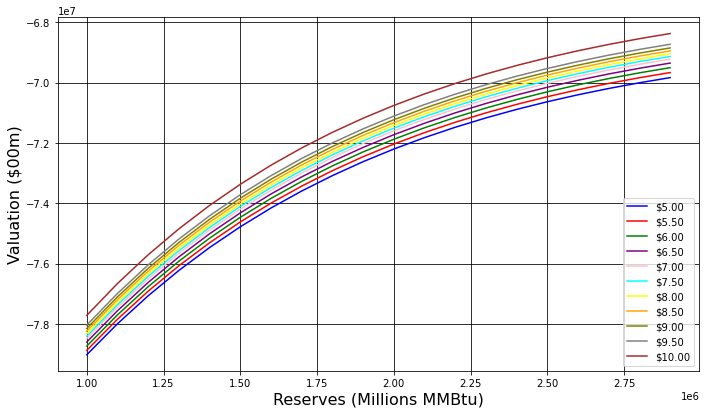

In [5]:
## regime 1 price variation ##

opt_surface_ex1 = temp_node[0,8,:,1,1]
opt_surface_ex2 = temp_node[0,9,:,1,1]
opt_surface_ex3 = temp_node[0,10,:,1,1]
opt_surface_ex4 = temp_node[0,11,:,1,1]
opt_surface_ex5 = temp_node[0,12,:,1,1]
opt_surface_ex6 = temp_node[0,13,:,1,1]
opt_surface_ex7 = temp_node[0,14,:,1,1]
opt_surface_ex8 = temp_node[0,15,:,1,1]
opt_surface_ex9 = temp_node[0,16,:,1,1]
opt_surface_ex10 = temp_node[0,17,:,1,1]
opt_surface_ex11 = temp_node[0,18,:,1,1]


fig = plt.gcf()
fig.set_size_inches(11.5, 6.5)
plt.plot(s0_grid,opt_surface_ex1,color="blue")
plt.plot(s0_grid,opt_surface_ex2,color="red")
plt.plot(s0_grid,opt_surface_ex3,color="green")
plt.plot(s0_grid,opt_surface_ex4,color="purple")
plt.plot(s0_grid,opt_surface_ex5,color="pink")
plt.plot(s0_grid,opt_surface_ex6,color="cyan")
plt.plot(s0_grid,opt_surface_ex7,color="yellow")
plt.plot(s0_grid,opt_surface_ex8,color="orange")
plt.plot(s0_grid,opt_surface_ex9,color="olive")
plt.plot(s0_grid,opt_surface_ex10,color="gray")
plt.plot(s0_grid,opt_surface_ex11,color="brown")

plt.xlabel('Reserves (Millions MMBtu)', fontsize=16)
plt.ylabel('Valuation ($00m)', fontsize=16)
plt.legend(["$5.00", "$5.50", "$6.00", "$6.50", "$7.00", "$7.50", "$8.00", "$8.50", "$9.00", "$9.50", "$10.00"], loc ="lower right")
plt.grid(color="black")

plt.savefig('/Users/joe/Dropbox/PhD/Writing/TeX/Charts/sc_3_c_tax_valuationtest.png', dpi=600)






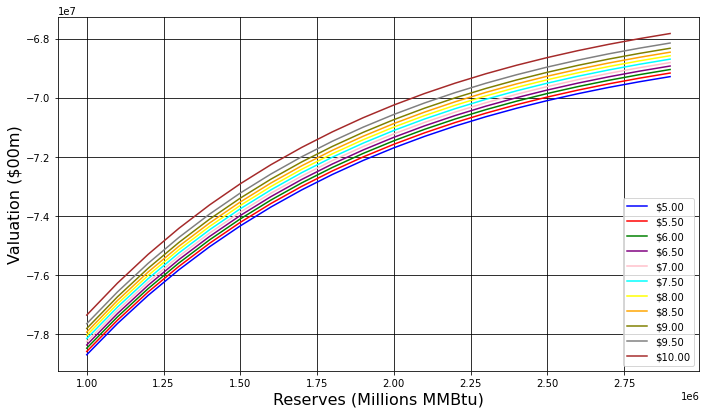

In [6]:
## regime 2 price variation ##

opt_surface_ex1 = temp_node[1,8,:,1,1]
opt_surface_ex2 = temp_node[1,9,:,1,1]
opt_surface_ex3 = temp_node[1,10,:,1,1]
opt_surface_ex4 = temp_node[1,11,:,1,1]
opt_surface_ex5 = temp_node[1,12,:,1,1]
opt_surface_ex6 = temp_node[1,13,:,1,1]
opt_surface_ex7 = temp_node[1,14,:,1,1]
opt_surface_ex8 = temp_node[1,15,:,1,1]
opt_surface_ex9 = temp_node[1,16,:,1,1]
opt_surface_ex10 = temp_node[1,17,:,1,1]
opt_surface_ex11 = temp_node[1,18,:,1,1]


fig = plt.gcf()
fig.set_size_inches(11.5, 6.5)
plt.plot(s0_grid,opt_surface_ex1,color="blue")
plt.plot(s0_grid,opt_surface_ex2,color="red")
plt.plot(s0_grid,opt_surface_ex3,color="green")
plt.plot(s0_grid,opt_surface_ex4,color="purple")
plt.plot(s0_grid,opt_surface_ex5,color="pink")
plt.plot(s0_grid,opt_surface_ex6,color="cyan")
plt.plot(s0_grid,opt_surface_ex7,color="yellow")
plt.plot(s0_grid,opt_surface_ex8,color="orange")
plt.plot(s0_grid,opt_surface_ex9,color="olive")
plt.plot(s0_grid,opt_surface_ex10,color="gray")
plt.plot(s0_grid,opt_surface_ex11,color="brown")

plt.xlabel('Reserves (Millions MMBtu)', fontsize=16)
plt.ylabel('Valuation ($00m)', fontsize=16)
plt.legend(["$5.00", "$5.50", "$6.00", "$6.50", "$7.00", "$7.50", "$8.00", "$8.50", "$9.00", "$9.50", "$10.00"], loc ="lower right")
plt.grid(color="black")

plt.savefig('/Users/joe/Dropbox/PhD/Writing/TeX/Charts/sc_4_c_tax_valuationtest.png', dpi=600)




